In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cetin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv("NetflixCSV")
df = data.copy()

In [4]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [6]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [9]:
df['date_added'] = df['date_added'].str.strip() #tarih verilerindeki boşlukları silme

df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')# date_added sütununu datetime tipine çevir

# Ek olarak: Netflix'e eklendiği yılı yeni bir sütuna alalım
print(df[df['date_added'].isna()][['title', 'date_added']])

df['year_added'] = df['date_added'].dt.year

                                            title date_added
6066  A Young Doctor's Notebook and Other Stories        NaT
6174              Anthony Bourdain: Parts Unknown        NaT
6795                                      Frasier        NaT
6806                                      Friends        NaT
6901                              Gunslinger Girl        NaT
7196                                     Kikoriki        NaT
7254                          La Familia P. Luche        NaT
7406                                        Maron        NaT
7847                                 Red vs. Blue        NaT
8182                 The Adventures of Figaro Pho        NaT


In [10]:
df = df.dropna(subset=['date_added'])
print("temizlendikten sonra veri seti boyutu:", df.shape)

temizlendikten sonra veri seti boyutu: (8797, 13)


C:\Users\Cetin\AppData\Local\Temp\ipykernel_12772\1125117677.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,x='year_added',palette='viridis')


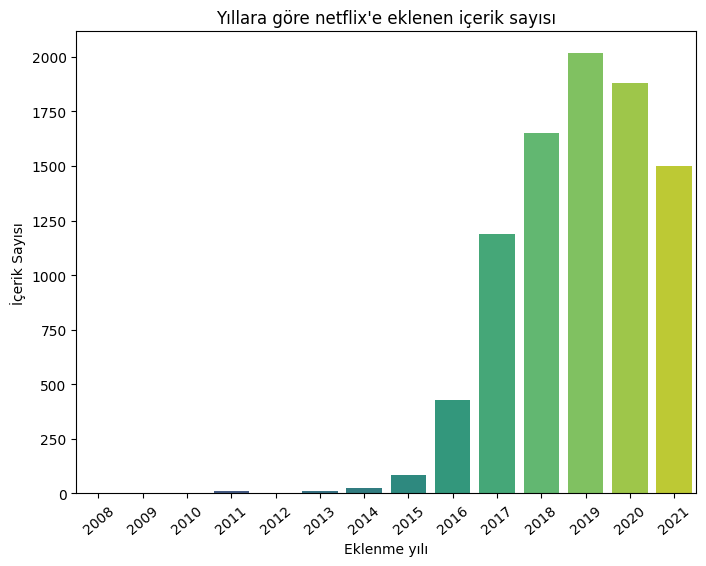

In [18]:
df['year_added'] = df['year_added'].astype(int)
plt.figure(figsize=(8,6))
sns.countplot(data=df,x='year_added',palette='viridis')
plt.title("Yıllara göre netflix'e eklenen içerik sayısı")
plt.xlabel("Eklenme yılı")
plt.ylabel("İçerik Sayısı")
plt.xticks(rotation=40)
plt.show()

C:\Users\Cetin\AppData\Local\Temp\ipykernel_12772\1706655658.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df , x='type' , palette='viridis')


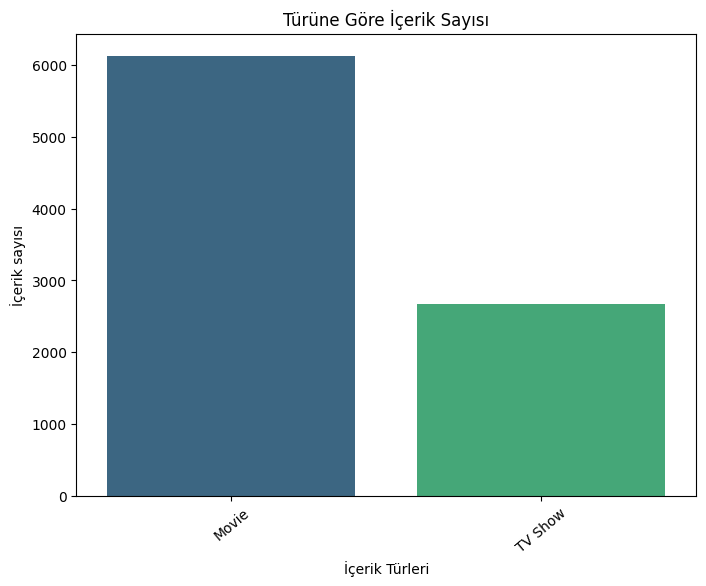

In [24]:
plt.figure(figsize=(8,6))
sns.countplot(data=df , x='type' , palette='viridis')
plt.title('Türüne Göre İçerik Sayısı')
plt.xlabel('İçerik Türleri')
plt.ylabel('İçerik sayısı')
plt.xticks(rotation=40)
plt.show()

C:\Users\Cetin\AppData\Local\Temp\ipykernel_12772\2530109508.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='coolwarm')


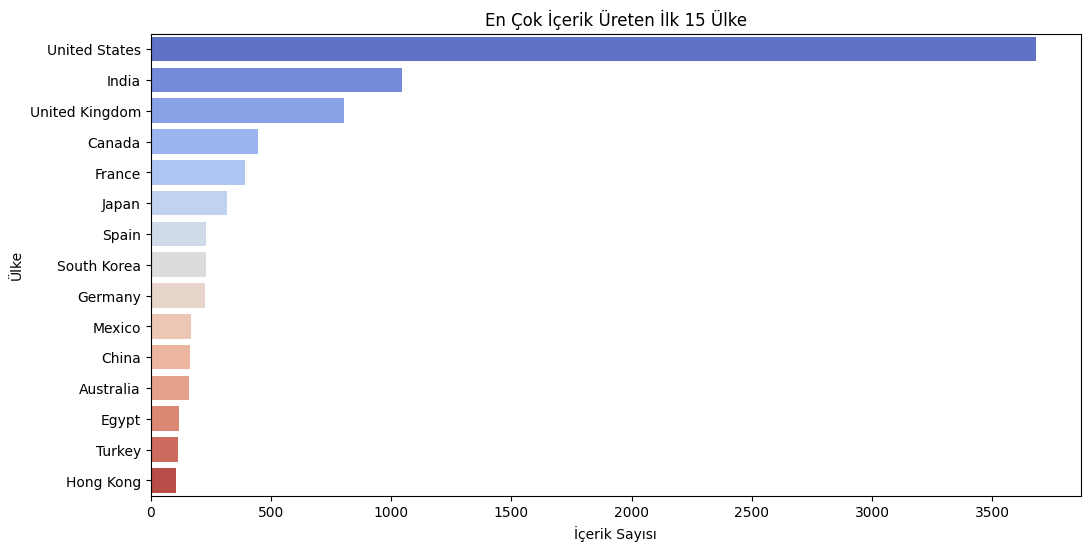

In [29]:
# country sütunundaki birden fazla ülkeyi ayır ve her ülkeyi ayrı satır yap
df_countries = df.assign(country=df['country'].str.split(', ')).explode('country')

# En çok içerik olan ilk 15 ülkeyi al
top_countries = df_countries['country'].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='coolwarm')
plt.title('En Çok İçerik Üreten İlk 15 Ülke')
plt.xlabel('İçerik Sayısı')
plt.ylabel('Ülke')
plt.show()

C:\Users\Cetin\AppData\Local\Temp\ipykernel_12772\4150399232.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='mako')


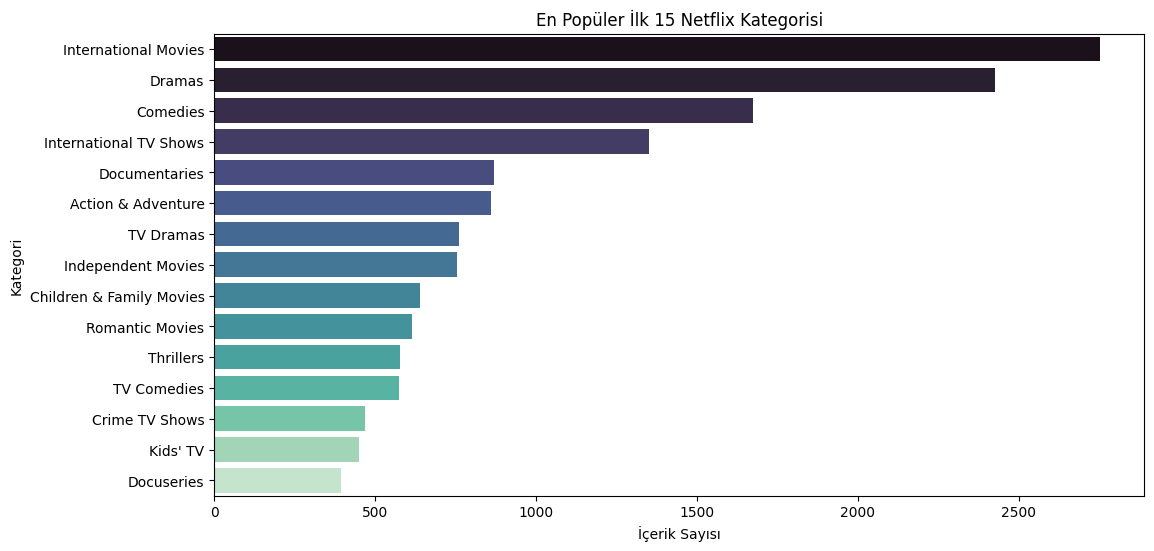

In [30]:
df_categories = df.assign(category=df['listed_in'].str.split(', ')).explode('category')

top_categories = df_categories['category'].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='mako')
plt.title('En Popüler İlk 15 Netflix Kategorisi')
plt.xlabel('İçerik Sayısı')
plt.ylabel('Kategori')
plt.show()

In [34]:
stop_words = set(nltk.corpus.stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # küçük harfe çevir
    text = ''.join([ch for ch in text if ch not in string.punctuation])  # noktalama kaldır
    words = text.split()
    words = [w for w in words if w not in stop_words]  # stopword çıkar
    return ' '.join(words)

# Açıklamaları temizle
df['clean_description'] = df['description'].apply(clean_text)

# TF-IDF vektörleştirme
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['clean_description'])

# Benzerlik matrisi
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Film isimleri ve indekslerini eşle
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [39]:
def recommend(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # en benzer 5 içerik (ilk kendisi olduğu için çıkarıldı)
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

In [40]:
movie_name = input("Film adı giriniz : ")
print(recommend(movie_name))

Film adı giriniz :  Narcos


2921                         Narcos: Mexico
7463                          Miss Dynamite
625                                  Somos.
4750                               El Chapo
310     Cocaine Cowboys: The Kings of Miami
Name: title, dtype: object
